In [1]:
from fastai.vision.all import *

In [2]:
def train_fairface_model(train_df, arch=resnet34, epochs=10, bs=64, lr=1e-3):
    fairface_block = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock),
        get_x=ColReader('file', pref='./Dataset/'),  
        get_y=ColReader(['age', 'gender', 'race']),
        splitter=ColSplitter('is_valid'),  
        item_tfms=Resize(224),
        batch_tfms=aug_transforms(mult=1.0, max_rotate=20.0, max_zoom=1.2, max_warp=0.2, p_affine=0.75)
    )

    dls = fairface_block.dataloaders(train_df, bs=bs)
    
    dls.show_batch()

    learn = vision_learner(dls, arch, metrics=[partial(accuracy_multi, thresh=0.5)])

    learn.lr_find()

    learn.fine_tune(
        epochs,
        base_lr=lr,
        cbs=[
            SaveModelCallback(monitor='valid_loss'),
            EarlyStoppingCallback(monitor='valid_loss', patience=3), 
            ReduceLROnPlateau(monitor='valid_loss', patience=2)  
        ]
    )
    
    learn.show_results()

    learn.export('../models/fairface_v3.pkl')
    torch.save(learn.model.state_dict(), '../models/fairface_v3.pth')

    return learn



epoch,train_loss,valid_loss,accuracy_multi,time
0,0.362593,0.342486,0.857632,11:59


Better model found at epoch 0 with valid_loss value: 0.342485636472702.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.316116,0.293582,0.876545,15:21
1,0.279243,0.256037,0.890030,15:26
2,0.261593,0.233179,0.897892,15:21
3,0.241560,0.221312,0.902613,15:21
4,0.234207,0.214313,0.905448,15:32
5,0.226444,0.208035,0.908278,15:34
6,0.217691,0.205452,0.909364,15:42
7,0.212612,0.202978,0.910601,15:46
8,0.209570,0.201359,0.911727,15:46
9,0.205112,0.200163,0.911869,15:52


Better model found at epoch 0 with valid_loss value: 0.2935818135738373.
Better model found at epoch 1 with valid_loss value: 0.2560372054576874.
Better model found at epoch 2 with valid_loss value: 0.23317885398864746.
Better model found at epoch 3 with valid_loss value: 0.2213120013475418.
Better model found at epoch 4 with valid_loss value: 0.21431301534175873.
Better model found at epoch 5 with valid_loss value: 0.20803460478782654.
Better model found at epoch 6 with valid_loss value: 0.20545178651809692.
Better model found at epoch 7 with valid_loss value: 0.2029777467250824.
Better model found at epoch 8 with valid_loss value: 0.2013593167066574.
Better model found at epoch 9 with valid_loss value: 0.20016315579414368.
Better model found at epoch 10 with valid_loss value: 0.19931690394878387.


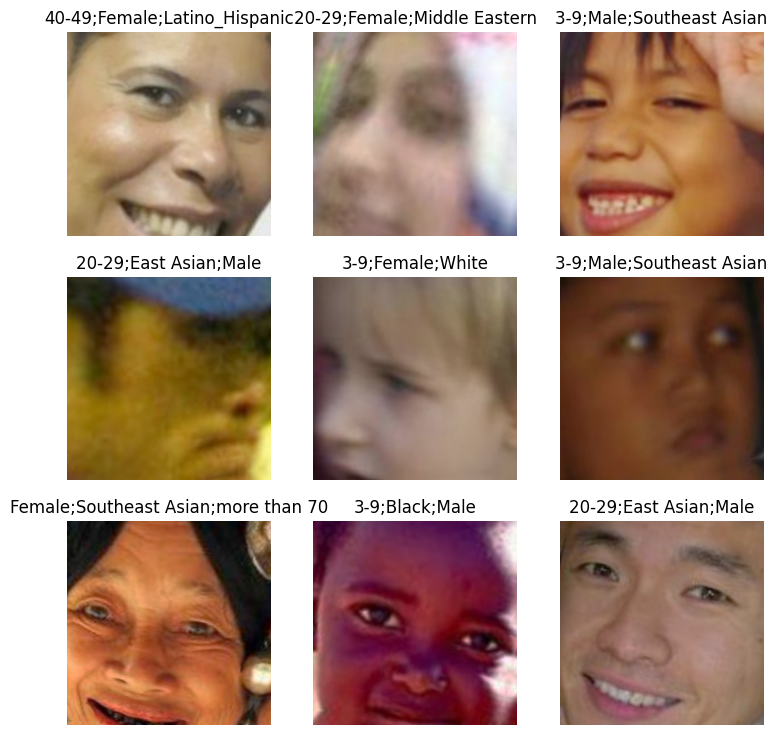

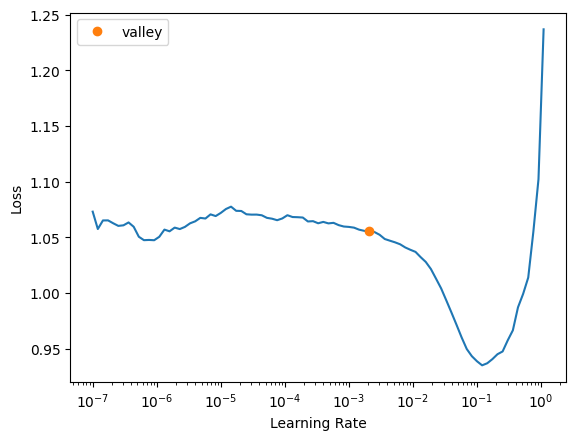

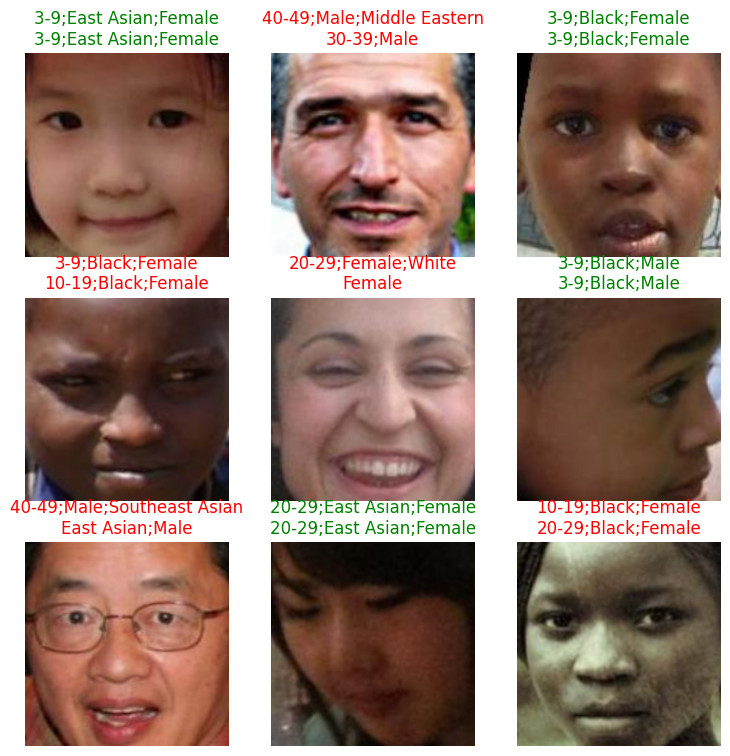

In [3]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test'])

train_df['file'] = train_df['file'].str.replace('train', 'face_train')
val_df['file'] = val_df['file'].str.replace('val', 'face_val')

train_df['is_valid'] = False
val_df['is_valid'] = True

combined_df = pd.concat([train_df, val_df])

learn = train_fairface_model(combined_df, arch=resnet50, epochs=12, bs=32, lr=1e-3)

In [4]:
from facenet_pytorch import MTCNN

mtcnn = MTCNN(
    image_size=224,
    margin=20,
    keep_all=True,
    post_process=True,
    select_largest=False,
    thresholds=[0.6, 0.7, 0.7]  
)

def detect_face_mtcnn(image_path):
    img = Image.open(image_path).convert('RGB')
    faces, _ = mtcnn.detect(img)
    
    if faces is None:
        return img 

    face_images = []
    for (x1, y1, x2, y2) in faces:
        face = img.crop((x1, y1, x2, y2))
        face_images.append(face)
    
    return face_images[0] if face_images else img

age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']

img_face = detect_face_mtcnn('./Dataset/val/1.jpg')
pred, pred_idx, probs = learn.predict(img_face)

age_probs = probs[:len(age_labels)]
gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
race_probs = probs[len(age_labels) + len(gender_labels):]

print("Age Category Probabilities:")
for label, prob in zip(age_labels, age_probs):
    print(f'{label}: {prob:.4f}')

print("\nGender Category Probabilities:")
for label, prob in zip(gender_labels, gender_probs):
    print(f'{label}: {prob:.4f}')

print("\nRace Category Probabilities:")
for label, prob in zip(race_labels, race_probs):
    print(f'{label}: {prob:.4f}')

Age Category Probabilities:
0-2: 0.0003
3-9: 0.2332
10-19: 0.0074
20-29: 0.7102
30-39: 0.0016
40-49: 0.0003
50-59: 0.0000
60-69: 0.0000
more than 70: 0.0009

Gender Category Probabilities:
Male: 0.1805
Female: 0.1044

Race Category Probabilities:
White: 0.0376
Black: 0.2589
East Asian: 0.8956
Southeast Asian: 0.0012
Indian: 0.5234
Middle Eastern: 0.0038
Latino_Hispanic: 0.0000
